In [1]:
# !sudo pip3 install cython
# !sudo pip3 install cartopy
# !sudo pip3 install geoplot
# !sudo pip3 install descartes
# !sudo pip3 install pysal
# !sudo pip3 install geopandas

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import requests
import json
import geopandas as gpd
import pandas as pd
import ast
import numpy as np

In [3]:
# To plot the choropleths, we need the shapefiles for the areas. Below we use 
# shapefiles that come from the US Census data
# 
# More files at https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html
# 
# Check also http://geojson.xyz/ for more shapefiles
#
shapefiles_zipcodes = "http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_zcta510_500k.zip"
shapefiles_counties = "http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_county_500k.zip"
shapefiles_states = "http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_500k.zip"

## Load GeoDataframe for US States and plot a map

In [4]:
df_states = gpd.read_file(shapefiles_states)

In [5]:
# df_states

In [6]:
# Dropping non-continental states
df_states = df_states[ df_states.NAME!='Alaska' ] 
df_states = df_states[ df_states.NAME!='Hawaii' ] 
df_states = df_states[ df_states.NAME!='Puerto Rico' ] 
df_states = df_states[ df_states.NAME!='Guam' ] 
df_states = df_states[ df_states.NAME!='Commonwealth of the Northern Mariana Islands' ] 
df_states = df_states[ df_states.NAME!='American Samoa' ] 
df_states = df_states[ df_states.NAME!='United States Virgin Islands' ] 

In [7]:
# Should be 49. The 48 continental, plus DC
assert( len(df_states) == 49 )

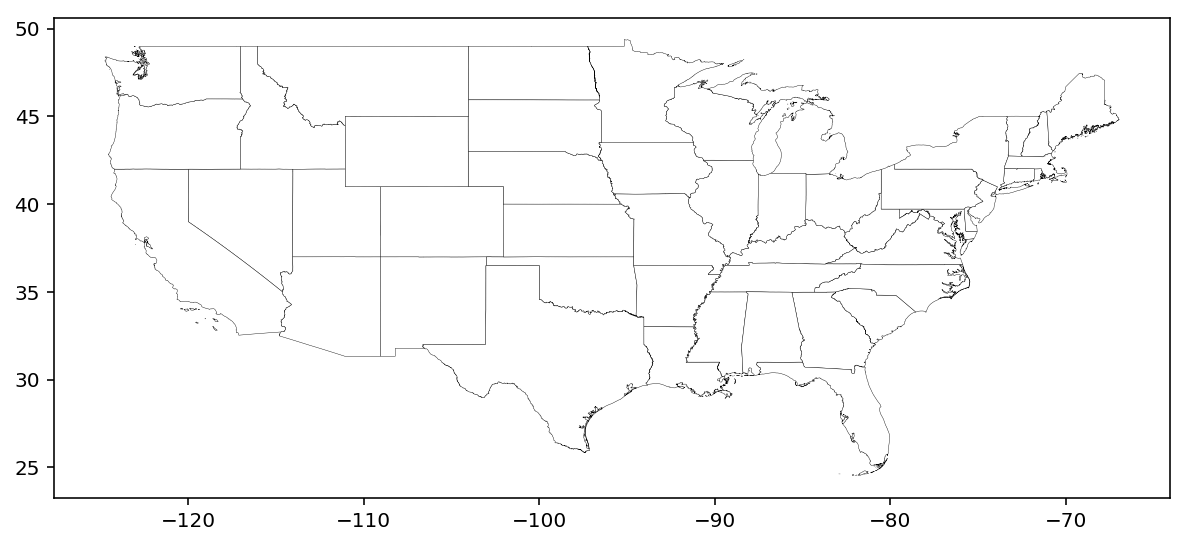

In [10]:
df_states.plot(
    figsize=(10,10), 
    linewidth=0.2, 
    color='white', 
    edgecolor='black'
)

## Load US Counties Datafame and plot a map

In [11]:
df_counties = gpd.read_file(shapefiles_counties)

In [12]:
# df_counties

In [13]:
len(df_counties)

3233

In [14]:
# There should be 3233 counties looaded
assert( len(df_counties) == 3233 )

In [15]:
# Keep only counties in the lower 48 states + DC
keep_county = df_counties.STATEFP.isin(df_states.STATEFP.values)
df_counties = df_counties[ keep_county ]

In [16]:
# There should be 3108 counties remaining
assert(len(df_counties) == 3108)

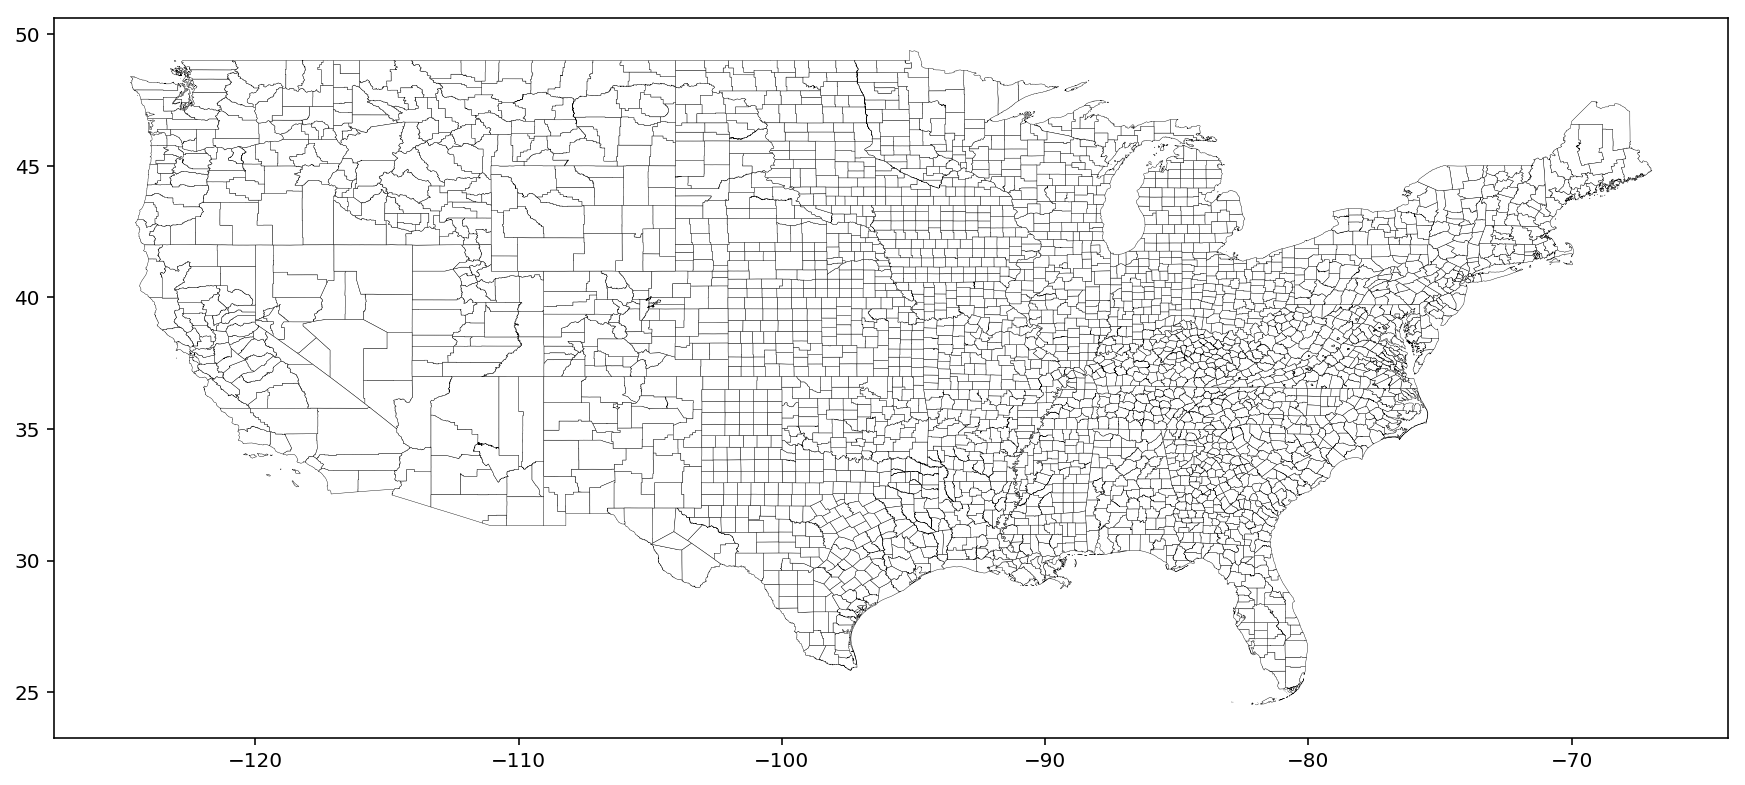

In [17]:
df_counties.plot(
    figsize=(15,15), 
    linewidth=0.2,  
    color='white', 
    edgecolor='black'
)

## Getting Census Data

You need to get an API Key from http://api.census.gov/data/key_signup.html.

In [18]:
class Census:
    def __init__(self, key):
        self.key = key

    def get(self, fields, geo, year=2010, dataset='sf1'):
        fields = [','.join(fields)]
        template_url = 'https://api.census.gov/data/{year}/{dataset}?key={key}&get='
        base_url = template_url.format(year=str(year), dataset=dataset, key=self.key)
        query = fields
        for item in geo:
            query.append(item)
        add_url = '&'.join(query)
        url = base_url + add_url
        response = requests.get(url)
        return ast.literal_eval(response.text) 

api_key = '627d4107b57d4576f2120d2b87b59c7440e5d2af'
census = Census(api_key)

## Plot a Choropleth with Population of US States

In [19]:
# Fetch state population data from US Census
census_response = census.get(['P0010001'], ['for=state:*'])
# Manipulate the result from the US Census API and convert the result to a dataframe
df_state_population = pd.DataFrame(census_response[1:], columns = ['Population', 'STATEFP'])
df_state_population['Population'] = pd.to_numeric(df_state_population['Population'])
df_state_population['LogPopulation'] = np.log10(df_state_population['Population'])
# df_state_population

In [20]:
# ax = df_state_population.LogPopulation.hist()
# df_state_population.LogPopulation.plot.kde(secondary_y=True, ax = ax)

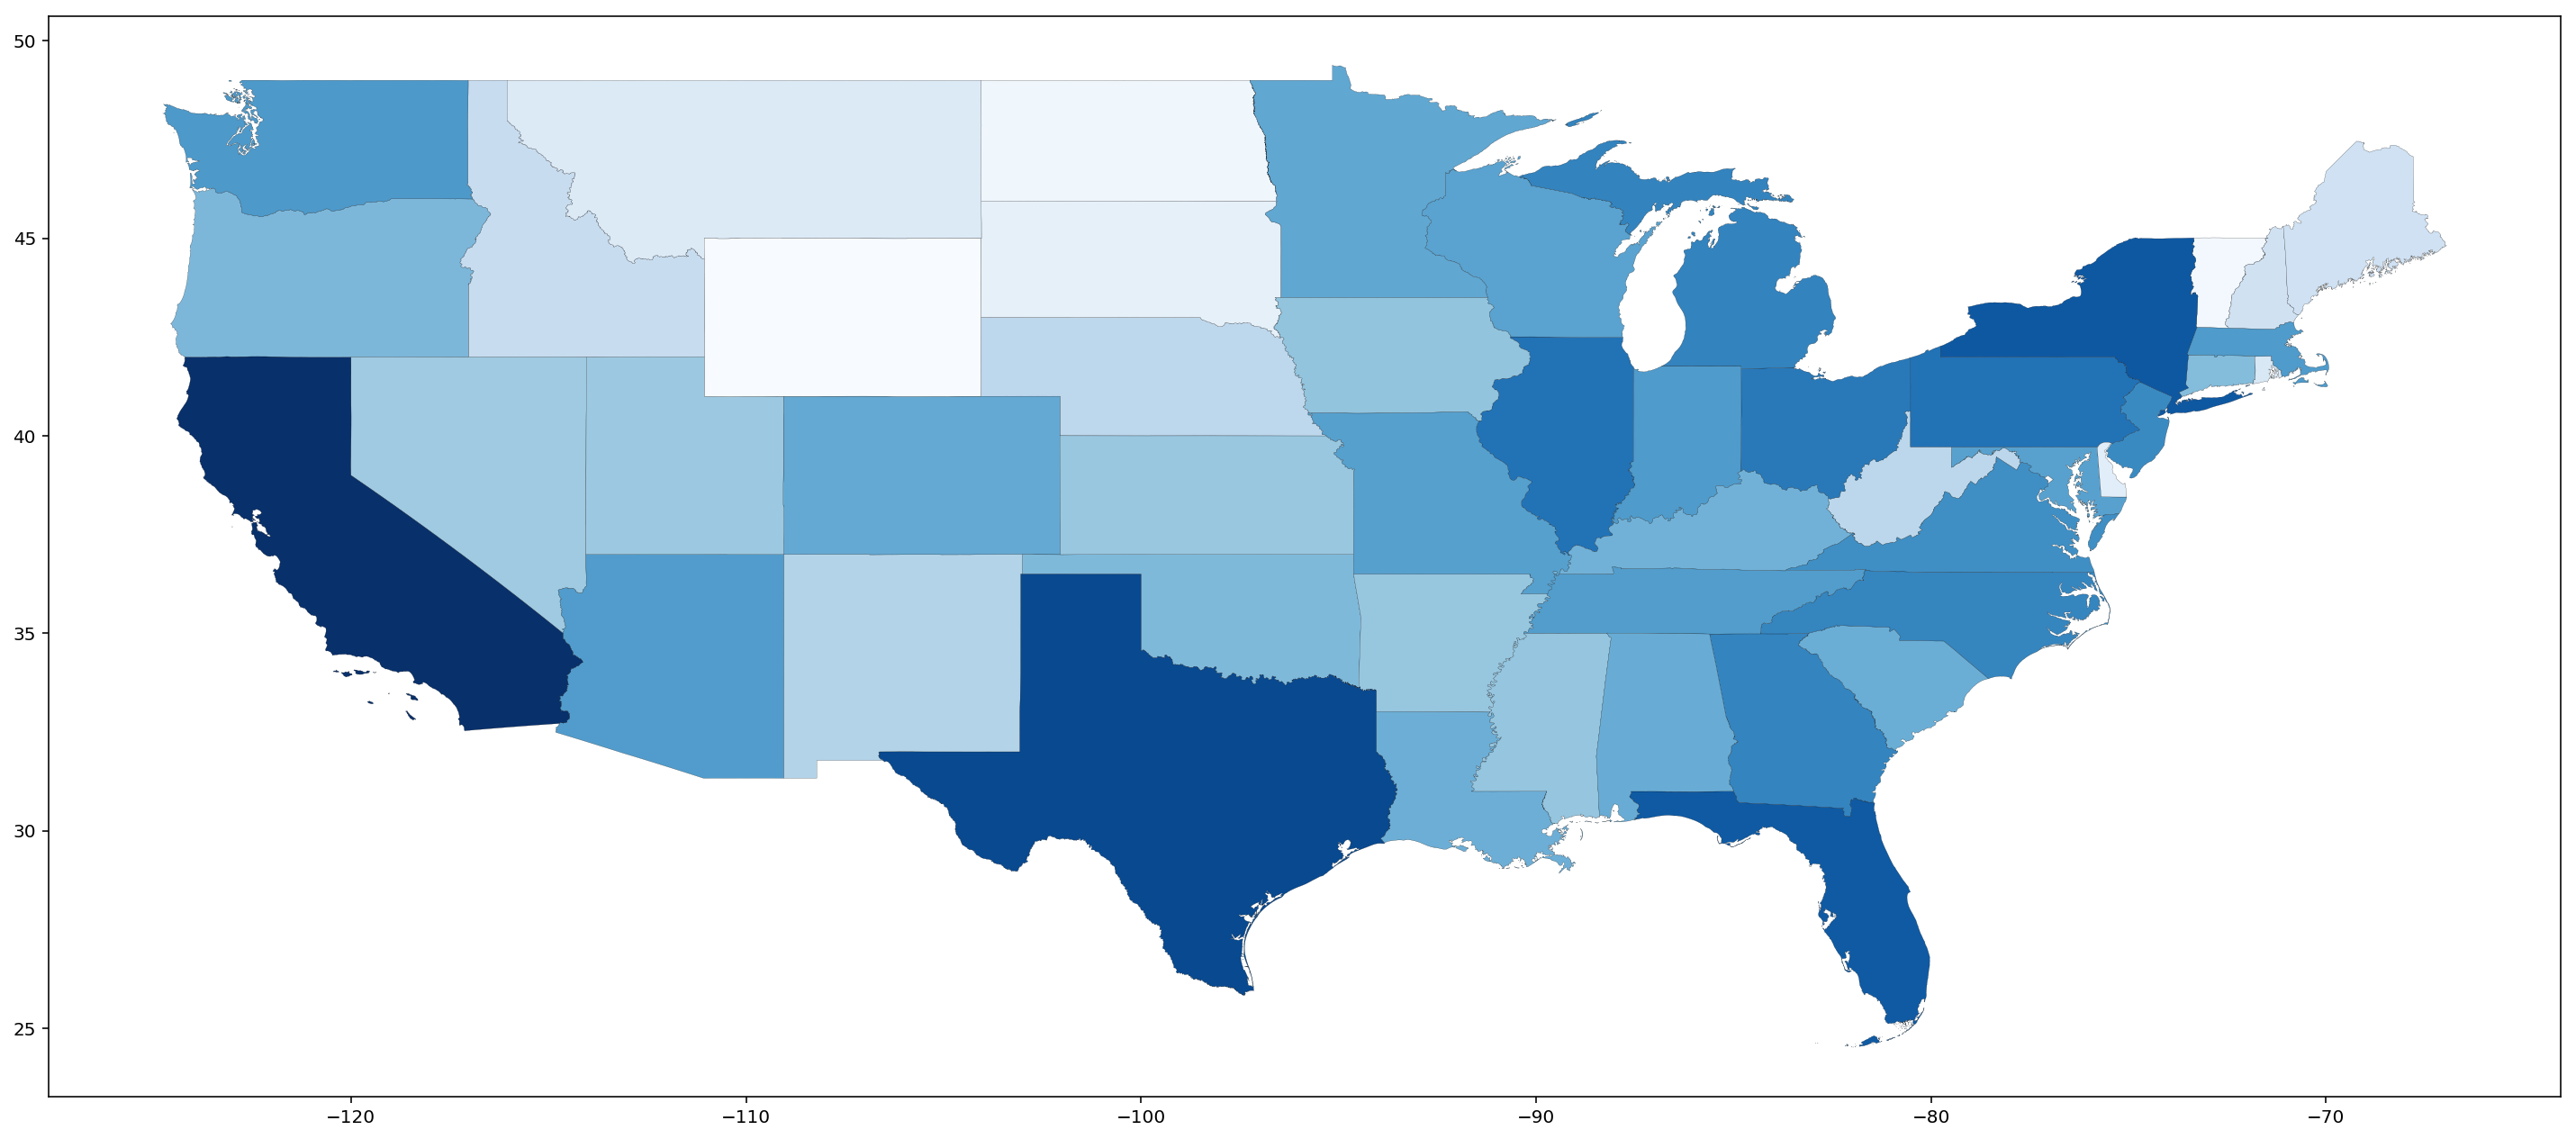

In [22]:
# Augment the df_states geodataframe with population information
states_choropleth = pd.merge(df_states, df_state_population, on='STATEFP')

states_choropleth.plot(
    figsize=(25,25), 
    column='LogPopulation', 
    cmap='Blues',  # select color scheme from http://matplotlib.org/users/colormaps.html
    linewidth=0.1, 
    edgecolor='black'
)

## Plot a Choropleth with Population of US Counties

In [23]:
# Query the US Census API for the population of each county
census_response = census.get(['P0010001'], ['in=state:*', 'for=county:*'])
# Manipulate the API response and put the results in a dataframe
df_county_population = pd.DataFrame(census_response[1:], columns = ['Population', 'STATEFP', 'COUNTYFP'])
df_county_population['Population'] = pd.to_numeric(df_county_population['Population'])
df_county_population['LogPopulation'] = np.log10(df_county_population['Population'])
# df_county_population

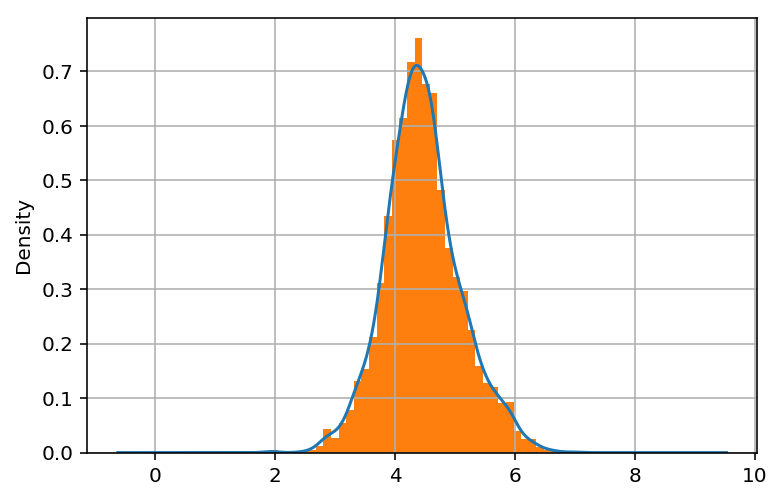

In [24]:
df_county_population.LogPopulation.plot.kde()
df_county_population.LogPopulation.hist(bins=40, density=True)

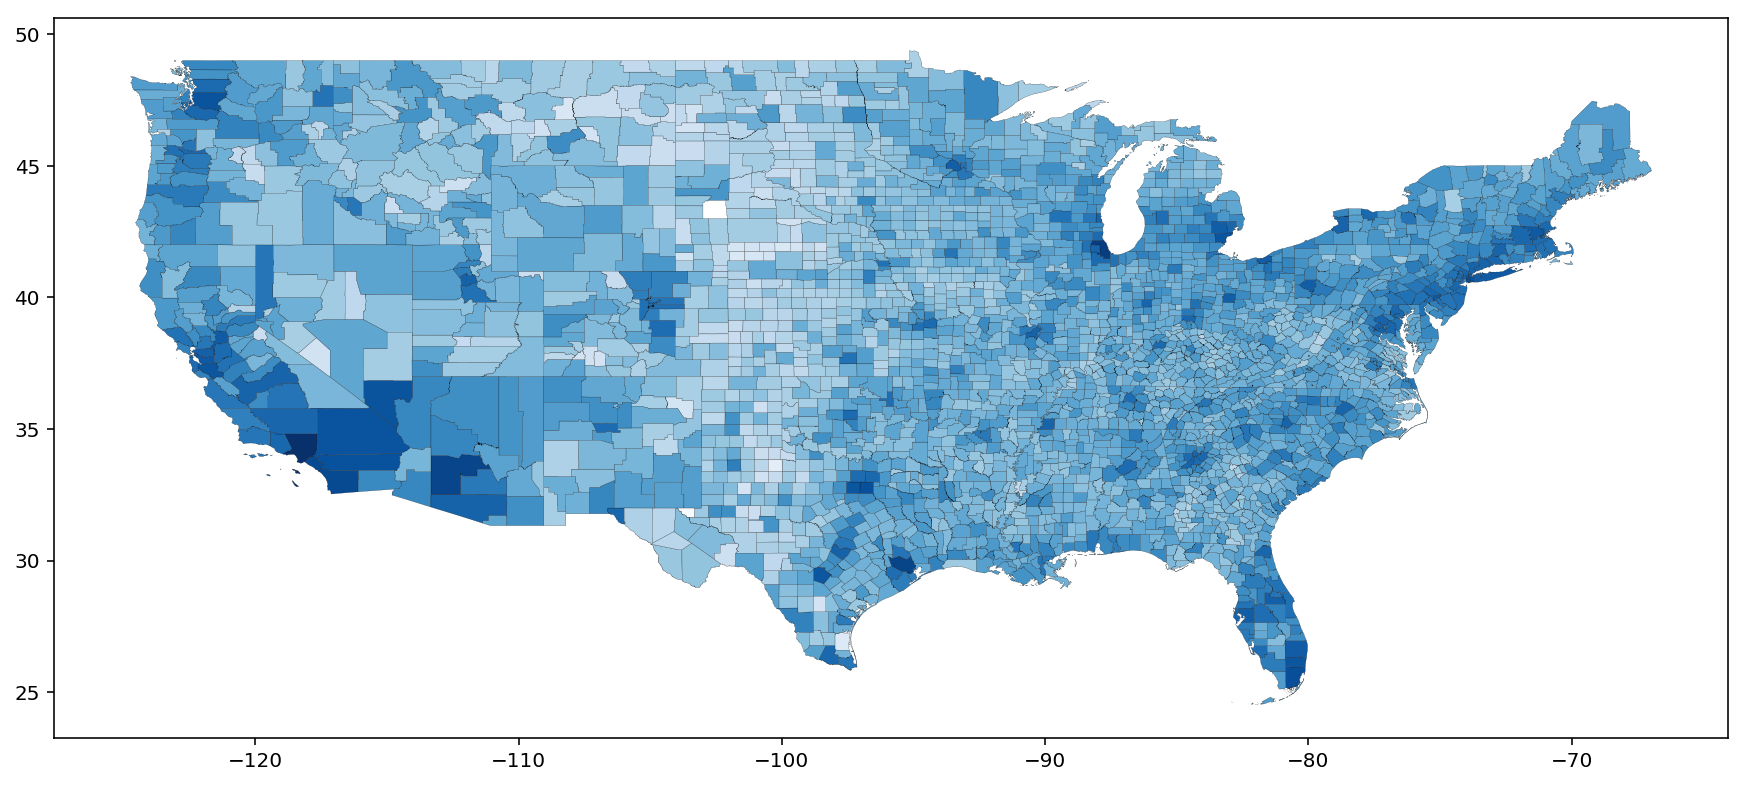

In [25]:
# Merge the GeoDataFrame df_counties with the population data
counties_choropleth = pd.merge(df_counties, df_county_population, on=['STATEFP', 'COUNTYFP'])

counties_choropleth.plot(
    figsize=(15,15), 
    column='LogPopulation', 
    cmap='Blues', # http://matplotlib.org/users/colormaps.html
    # scheme='Quantiles', # alternatives are 'Quantiles', Equal_Interval', and 'Fisher_Jenks'; Quantiles requires PySAL
    linewidth=0.1, 
    edgecolor='black')

## Extras

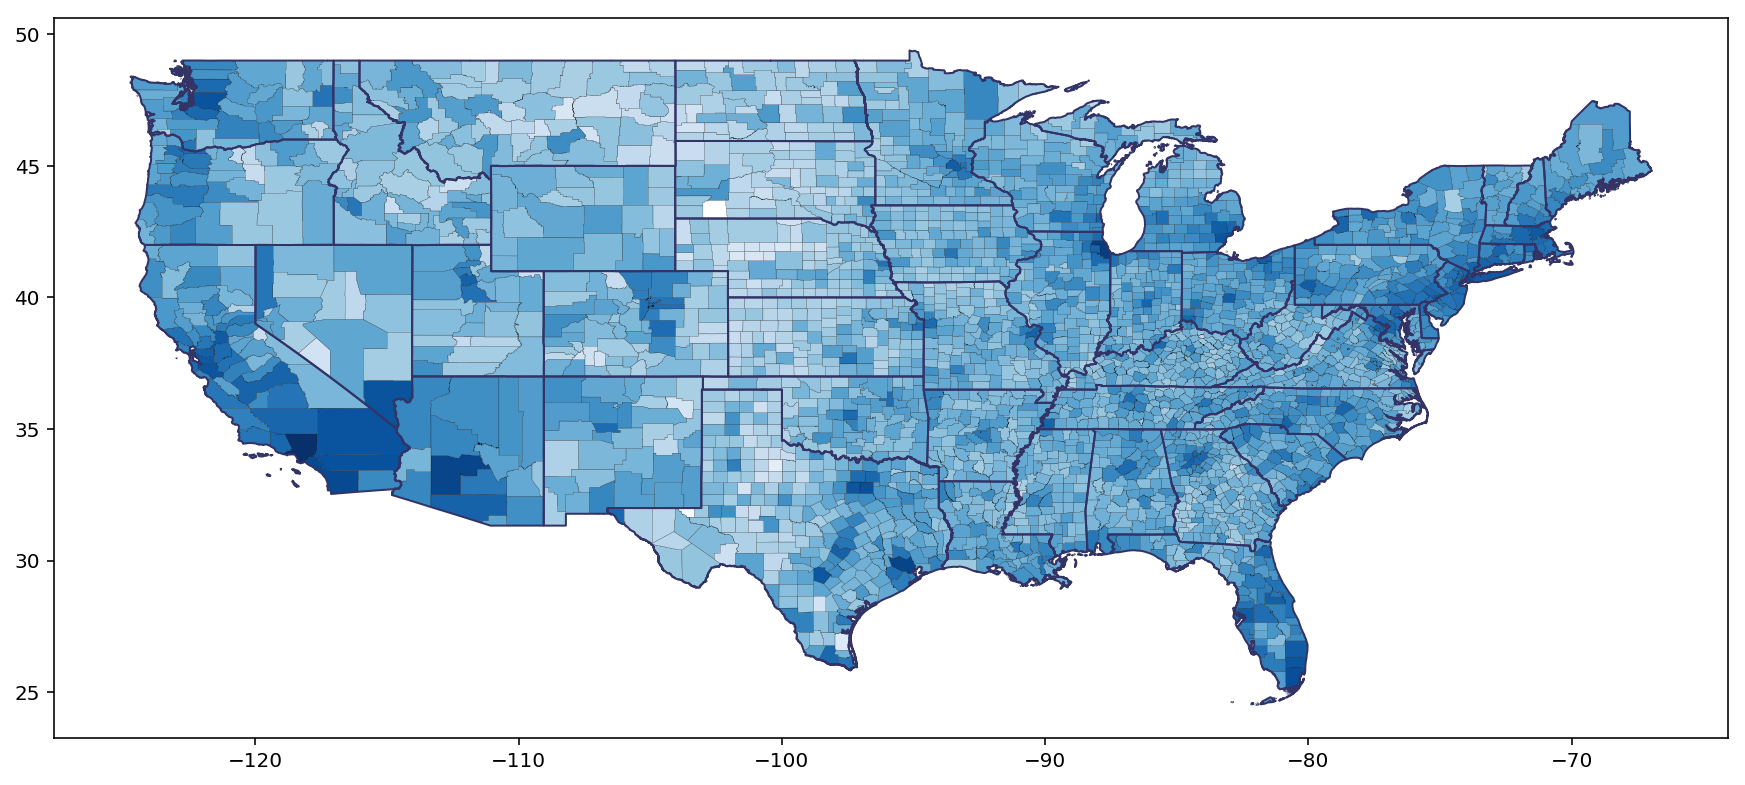

In [26]:
# Plot the state borders (with darker, thicker lines) on top of the counties

ax = counties_choropleth.plot(
    figsize=(15,15), 
    column='LogPopulation', 
    cmap='Blues', # http://matplotlib.org/users/colormaps.html
    # scheme='Quantiles', # alternatives are 'Quantiles', Equal_Interval', and 'Fisher_Jenks'; Quantiles requires PySAL
    linewidth=0.1, 
    edgecolor='black')

df_states.plot(
    figsize=(15,15), 
    linewidth=1, # thicker line
    facecolor='none', # no color for fill
    edgecolor='#333366', # color for the state borders
    ax = ax # plot it on top of the counties plot
)


/usr/local/lib/python3.6/dist-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


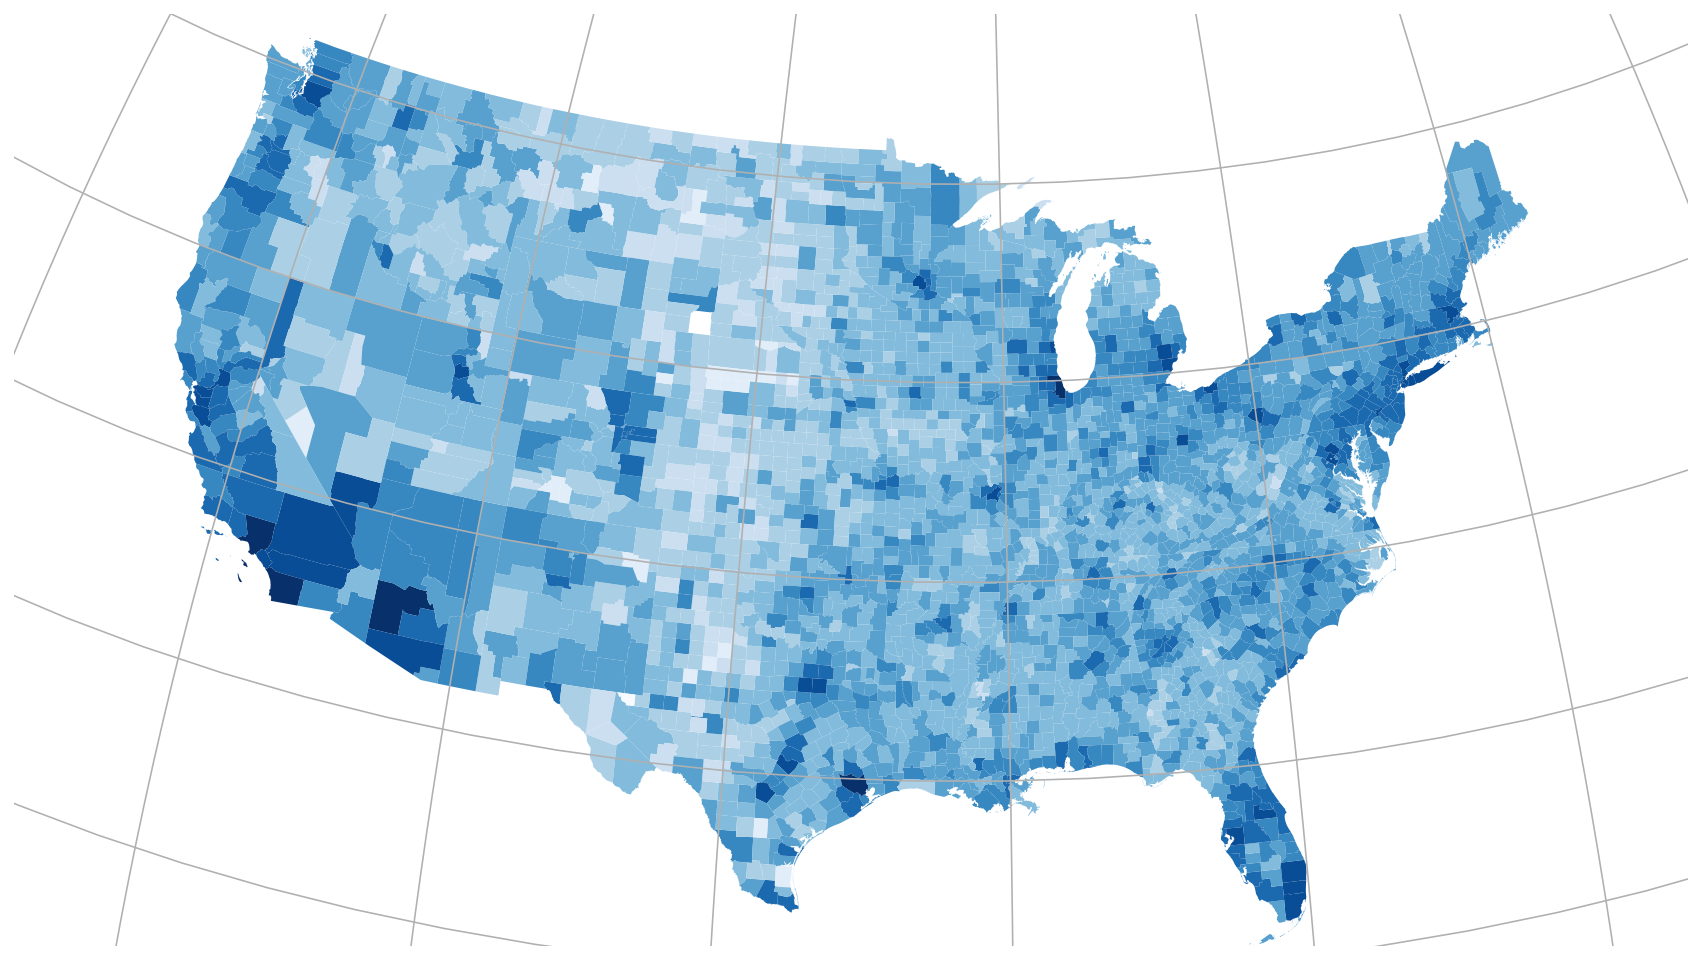

In [27]:
# Changing the projection to Orthographic

import geoplot
import geoplot.crs as gcrs

geoplot.choropleth(
    counties_choropleth,
    hue='LogPopulation',
    categorical=False, # LogPopulation is continuous not categorical
    k=10, # split LogPopulation into 10 bins for coloring
    scheme='equal_interval', # Each bin has equal range for LogPopulation
    cmap='Blues', # try Spectral_r, Spectral, or others from https://matplotlib.org/tutorials/colors/colormaps.html
    linewidth=0.3,
    projection=gcrs.Orthographic(),
    figsize=(15, 15)
).gridlines() # plot gridlines

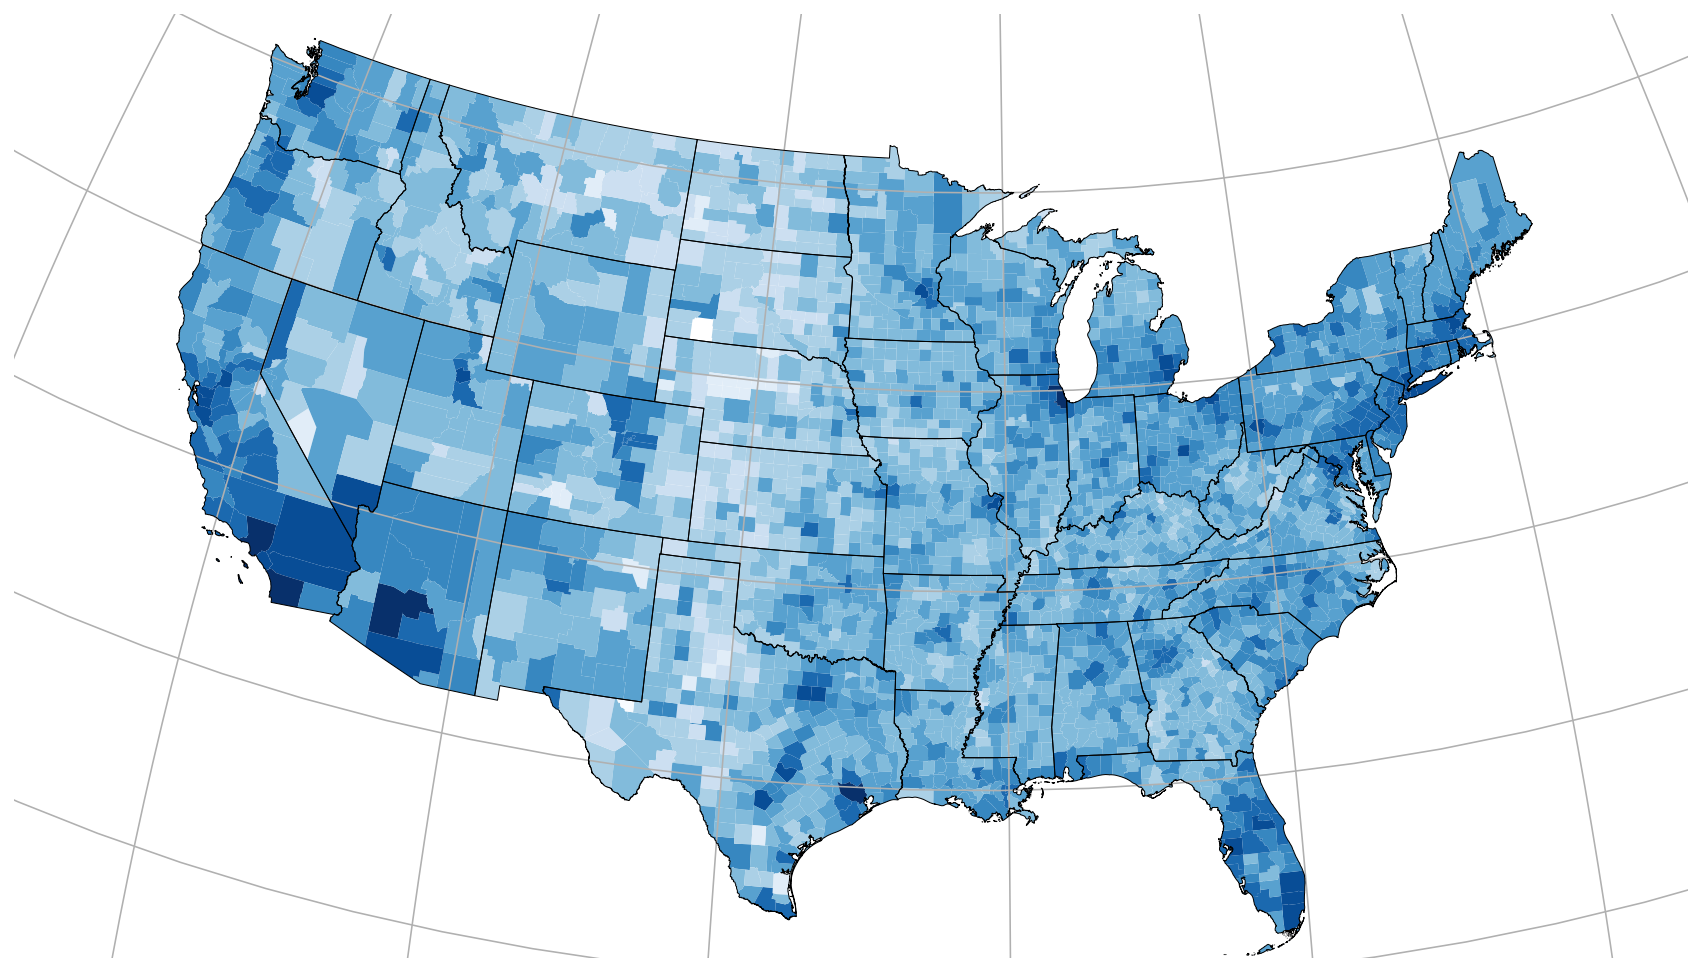

In [28]:
# Add state borders in the geoplot choropleth plot

ax = geoplot.polyplot(
    states_choropleth, 
    projection=gcrs.Orthographic(),
    figsize=(15, 15),
    linewidth = 0.5,
    zorder = 2
)

geoplot.choropleth(
    counties_choropleth,
    hue='LogPopulation',
    categorical=False, # LogPopulation is continuous not categorical
    k=10, # split LogPopulation into 40 bins for coloring
    scheme='equal_interval', # Each bin has equal range for LogPopulation
    cmap='Blues', # try Spectral_r, Spectral, or others from https://matplotlib.org/tutorials/colors/colormaps.html
    linewidth=0.3,
    projection=gcrs.Orthographic(),
    figsize=(15, 15),
    ax = ax,
    zorder = 0
).gridlines(zorder=1) # plot gridlines

